<b>AML2019</b>

### Useful links

- [Lin reg on Boston Housing dataset](https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155)
- [Lin reg in sckit learn](https://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/)
- [Train test split and cross validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
- [Ridge and Lasso regression](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b)
- [Best article in Boston House Pricing](https://gogul09.github.io/software/regression-example-boston-housing-prices)

In [263]:
# Install the library we need for the notebook
!pip3 install --user 'xgboost'

    100% |################################| 114.0MB 162kB/s 
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# For performance evaluation
from time import time 
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer

os.environ["OPENBLAS_NUM_THREADS"] = "1"   # Required by implicit
base = "/mnt/workspace/AML-2019/Challenges/House_Pricing/challenge_data/" # path of data files

# display
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
pricesRawDF = pd.read_csv(base + 'Eivinds_train.csv')
null_values = pricesRawDF.isnull().sum().sort_values(ascending = False)
null_values[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

In [3]:
columns_with_NaN = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageType', 'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrType']
for col in columns_with_NaN:
    pricesRawDF[col] = pricesRawDF[col].fillna('NA')

pricesRawDF['MasVnrArea'] = pricesRawDF['MasVnrArea'].fillna(0)

pricesRawDF.isnull().sum().any()

True

In [4]:
# To check if number of unique elements in coloumn exceeds number of types in data description
# Only useful for columns with categorical data 
nr_column_categories = []

for column in pricesRawDF:
    nr_column_categories.append((column, pricesRawDF[column].nunique()))

for elements in nr_column_categories[:10]:
    print(elements)

('Id', 1460)
('MSSubClass', 15)
('MSZoning', 5)
('LotFrontage', 111)
('LotArea', 1073)
('Street', 2)
('Alley', 3)
('LotShape', 4)
('LandContour', 4)
('Utilities', 2)


In [5]:
# Transforming the categories we want to be numeric, to numeric values
from sklearn.preprocessing import LabelEncoder
from variables import cats_split, cats_num

# The categories we want to split
categorical_to_split = ['MSSubClass', 'MSZoning', 'Alley', 'LotConfig', 'Utilities',
                       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                       'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 
                       'MiscFeature', 'SaleType', 'SaleCondition']

# Casting the type of all columns we want to one-hot-key to strings
for cat in categorical_to_split:
    pricesRawDF[cat] = pricesRawDF[cat].astype(str, errors = 'ignore')

# Categories to make numerical
categorical_to_make_numerical = ['Street', 'LotShape', 'LandContour', 'LandSlope', 'CentralAir',
                                'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                                'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                                'PoolQC', 'Fence']

# Function to make desired columns numerical
def numerize(rawDF, complete_mapping_dictionary):
    DF = rawDF.copy()
    errors = []
    for mapping_dictionary in complete_mapping_dictionary:
        # Fetching column name
        col_name = mapping_dictionary['name']
        # Fetching column
        column_to_numerize = DF[col_name].copy()
        # Creating columns of same size, and correct type
        numerized_column = pd.Series(np.zeros([column_to_numerize.size]), dtype=np.int8, name=col_name)
        # Resetting error_counter
        error_counter = 0
        # Looping through elements of column
        for index, value in column_to_numerize.iteritems():
            if (value in mapping_dictionary):
                numerized_column.at[index] = mapping_dictionary[value]
            else:
                error_counter += 1
        # Merging numerized column into dataframe
        DF.drop(labels=col_name, axis=1, inplace=True)
        DF[col_name] = numerized_column
        # Appending errors to error vector
        errors.append((col_name, error_counter))
    return errors, DF

# Function for one-hot-encoding a single column, given the column and its possible categories
def split_and_filter(col_name, DF, categories):
    # Extracting column to split
    column_to_split = DF[col_name].copy()
    # Setting new names for columns
    new_col_names = [(col_name + '_' + category) for category in categories]
    # Creating expanded DF of zeros
    splitDF = pd.DataFrame(np.zeros([column_to_split.size,len(categories)], dtype = np.int8), columns = categories)
    # Resetting error_counter
    error_counter = 0
    # Looping through series and setting correct values in new DF
    for index, value in column_to_split.iteritems():
        # Checking if the value is valid, i.e exists in the set of possible categories for one column
        if (value in categories):
            splitDF.at[index, value] = 1
        else:
            error_counter += 1
    # Renaming columns of new dataframe
    splitDF.columns = new_col_names
    # Merging expansion of one column with full DataFrame
    newDF = pd.merge(DF, splitDF, left_index=True, right_index=True)
    # Dropping original column
    newDF.drop([col_name], axis=1, inplace=True)
    # Deleting unused dataframe and series to conserve memory
    del splitDF
    del column_to_split
    return error_counter, newDF

# Function to one-hot encode the entire dataframe given a dataframe and list of names for new columns
def category_splitting(rawDF, list_of_categories):
    first_err, newDF = split_and_filter(list_of_categories[0][0], rawDF, list_of_categories[0][1:])
    errors = [(list_of_categories[0][0], first_err)]
    for column_to_split in list_of_categories[1:]:
        nth_err, newDF = split_and_filter(column_to_split[0], newDF, column_to_split[1:])
        errors.append((column_to_split[0], nth_err))
    return errors, newDF

# Function to reformat a dataset to our desired format
def reformat_dataset(rawDF):
    num_errors, numerizedDF = numerize(rawDF, cats_num)
    split_errors, reformattedDF = category_splitting(numerizedDF, cats_split)
    errors = num_errors + split_errors
    return errors, reformattedDF

errors, rfmtDF = reformat_dataset(pricesRawDF)

In [6]:
from variables import error_detect

error_values = []
for defect_col_name in error_detect:
    err = [defect_col_name[0]]
    defect_col = pricesRawDF[defect_col_name[0]]
    categories = defect_col_name[1:]
    for index, value in defect_col.iteritems():
        if value not in categories:
            err.append(value)
    error_values.append(err)

# Find a way to print all the unique errors in each list-element of error_values
col2print = error_values[4]
for el in col2print:
    print(el)

MasVnrType
NA
NA
NA
NA
NA
NA
NA
NA


In [7]:
# Spelling-error-correcting function
def correct_known_spelling_errors(rawDF, reformattedDF):
    toReturnDF = reformattedDF.copy()
    cols_to_correct = ['BldgType', 'Exterior2nd']
    error_fix_count = 0
    ################## BldgType
    col = rawDF['BldgType']
    for index, value in col.iteritems():
        if value == '2fmCon':
            toReturnDF.at[index, 'BldgType_2FmCon'] = 1
            error_fix_count += 1
        elif value == 'Duplex':
            toReturnDF.at[index, 'BldgType_Duplx'] = 1
            error_fix_count += 1
     ################## Exterior2nd
    col = rawDF['Exterior2nd']
    for index, value in col.iteritems():
        if value == 'Wd Shng':
            toReturnDF.at[index, 'Exterior2nd_Wd Sdng'] = 1
            error_fix_count += 1
        elif value == 'CmentBd':
            toReturnDF.at[index, 'Exterior2nd_CemntBd'] = 1
            error_fix_count += 1
        elif value == 'Brk Cmn':
            toReturnDF.at[index, 'Exterior2nd_BrkComm'] = 1
            error_fix_count += 1
    print('Nr. of errors corrected: ', error_fix_count)
    return toReturnDF

rfmtDF = correct_known_spelling_errors(pricesRawDF, rfmtDF)

Nr. of errors corrected:  188


In [8]:
# Function to compensate for "Twnhs" spelling erorr
def twnhs_combiner(rawDF, reformattedDF):
    toReturnDF = reformattedDF.copy()
    error_fix_count = 0
    toReturnDF['BldgType_Twnhs'] = toReturnDF['BldgType_TwnhsI'] + toReturnDF['BldgType_TwnhsE']
    toReturnDF.drop(['BldgType_TwnhsI', 'BldgType_TwnhsE'], axis=1, inplace=True)
    BldgType_col = rawDF['BldgType']
    for index, value in BldgType_col.iteritems():
        if value == 'Twnhs':
            toReturnDF.at[index, 'BldgType_Twnhs'] = 1 
            error_fix_count += 1
    print('Nr. of errors corrected: ', error_fix_count)
    return toReturnDF

correctedDF = twnhs_combiner(pricesRawDF, rfmtDF)

Nr. of errors corrected:  43


In [9]:
testDataRawDF = pd.read_csv(base + 'test.csv')
null_values = testDataRawDF.isnull().sum().sort_values(ascending = False)
null_values[:20]

PoolQC          257
MiscFeature     253
Alley           244
Fence           206
FireplaceQu     126
LotFrontage      49
GarageCond       14
GarageType       14
GarageYrBlt      14
GarageFinish     14
GarageQual       14
BsmtExposure      5
BsmtCond          5
BsmtQual          5
BsmtFinType1      5
BsmtFinType2      5
MasVnrArea        2
MasVnrType        2
Electrical        1
LotConfig         0
dtype: int64

In [10]:
columns_with_NaN = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageType', 'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrType', 'Electrical']
for col in columns_with_NaN:
    testDataRawDF[col] = testDataRawDF[col].fillna('NA')

testDataRawDF['MasVnrArea'] = testDataRawDF['MasVnrArea'].fillna(0)

testDataRawDF.isnull().sum().any()

False

In [11]:
for cat in categorical_to_split:
    testDataRawDF[cat] = testDataRawDF[cat].astype(str, errors = 'ignore')

errors, rfmtTestDF = reformat_dataset(testDataRawDF)

for columns in errors:
    if(columns[1] > 0):
        print(columns)

('BldgType', 20)
('Exterior2nd', 20)
('MasVnrType', 2)
('Electrical', 1)


In [12]:
rfmtTestDF = correct_known_spelling_errors(testDataRawDF, rfmtTestDF)
correctedTestDF = twnhs_combiner(testDataRawDF, rfmtTestDF)

Nr. of errors corrected:  34
Nr. of errors corrected:  6


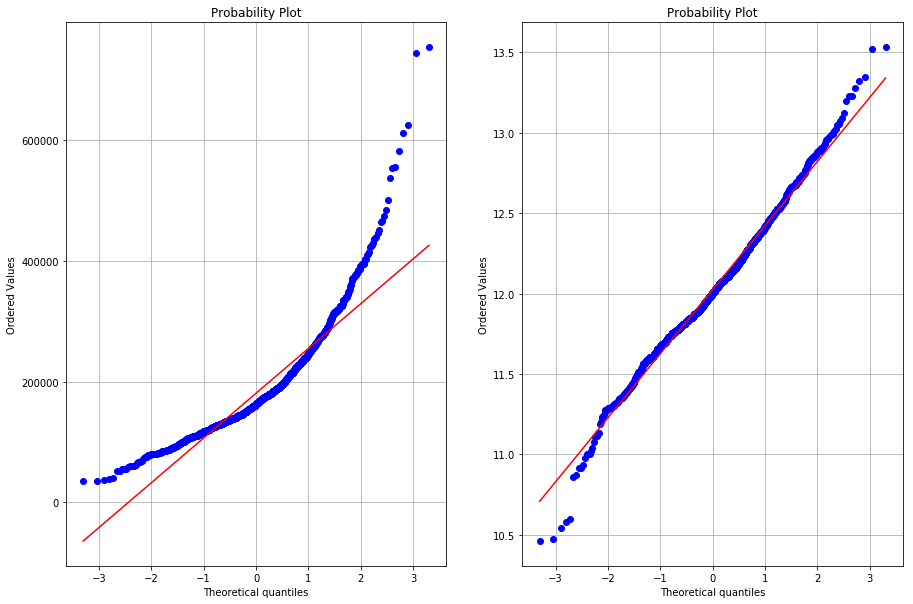

In [13]:
plt.figure(figsize=(15,10))

plt.subplot(121)
stats.probplot(correctedDF.SalePrice, plot=plt)
plt.grid()

plt.subplot(122)
stats.probplot(np.log(correctedDF.SalePrice), plot=plt)
plt.grid()

In [14]:
correctedTestDF.describe()

,Id,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Street,LotShape,LandContour,LandSlope,CentralAir,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_A,MSZoning_C (all),MSZoning_FV,MSZoning_I,MSZoning_RH,MSZoning_RL,MSZoning_RP,MSZoning_RM,Alley_Grvl,Alley_Pave,Alley_NA,Utilities_AllPub,Utilities_NoSewr,Utilities_NoSeWa,Utilities_ELO,LotConfig_Inside,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NoRidge,Neighborhood_NPkVill,Neighborhood_NridgHt,Neighborhood_NWAmes,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_RRNn,Condition1_RRAn,Condition1_PosN,Condition1_PosA,Condition1_RRNe,Condition1_RRAe,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_RRNn,Condition2_RRAn,Condition2_PosN,Condition2_PosA,Condition2_RRNe,Condition2_RRAe,BldgType_1Fam,BldgType_2FmCon,BldgType_Duplx,HouseStyle_1Story,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_CBlock,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_SBrkr,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,PavedDrive_Y,PavedDrive_P,PavedDrive_N,MiscFeature_Elev,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_NA,SaleType_WD,SaleType_CWD,SaleType_VWD,SaleType_New,SaleType_COD,SaleType_Con,SaleType_ConLw,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial,BldgType_2FmCon,BldgType_Twnhs
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.0000

In [15]:
correctedDF['TotalSquareFeet'] = correctedDF['TotalBsmtSF'] + correctedDF['1stFlrSF'] + correctedDF['2ndFlrSF']
correctedDF = correctedDF.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1) # drops old features

correctedTestDF['TotalSquareFeet'] = correctedTestDF['TotalBsmtSF'] + correctedTestDF['1stFlrSF'] + correctedTestDF['2ndFlrSF']
correctedTestDF = correctedTestDF.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1) # drops old features

Feature engineering

In [16]:
paramsDF = correctedDF.copy()
paramsDF.drop(['Id', 'SalePrice'], axis=1, inplace=True)
priceCorr = correctedDF.corr().abs()['SalePrice']
corrDF = paramsDF.corr(method="pearson").abs()

In [17]:
def remove_correlated_cols(trainDF, testDF, corr_limit):
    paramsDF = trainDF.copy()
    toReturnTrainDF = trainDF.copy()
    toReturnTestDF = testDF.copy()
    paramsDF.drop(['Id', 'SalePrice'], axis=1, inplace=True)
    priceCorr = trainDF.corr().abs()['SalePrice']
    corrDF = paramsDF.corr(method="pearson").abs()

    highly_correlated_columns = np.where(np.logical_and((corrDF > corr_limit),(corrDF < 1.0)))
    param_col_names = corrDF.columns
    redundant_cols = []
    correlatd_cols = []
    for index in range(len(highly_correlated_columns[0])):
        col_name1 = param_col_names[highly_correlated_columns[0][index]]
        col_name2 = param_col_names[highly_correlated_columns[1][index]]
        if (col_name1 not in redundant_cols) and (col_name2 not in redundant_cols):
            correlation = corrDF.iloc[highly_correlated_columns[0][index]][col_name2]
            correlatd_cols.append([col_name1, col_name2, correlation])
            #print(col_name1, col_name2, correlation)
            redundant_cols.append(col_name1)
            redundant_cols.append(col_name2)

    cols_to_remove = []
    for row in correlatd_cols:
        correlation1 = priceCorr[row[0]]
        correlation2 = priceCorr[row[1]]
        if correlation1 > correlation2:
            cols_to_remove.append(row[1])
        else:
            cols_to_remove.append(row[0])
    toReturnTrainDF.drop(cols_to_remove, axis=1, inplace=True)
    toReturnTestDF.drop(cols_to_remove, axis=1, inplace=True)
    return toReturnTrainDF, toReturnTestDF

featureReducedTrainDF, featureReducedTestDF = remove_correlated_cols(correctedDF, correctedTestDF, 0.7)
print(featureReducedTrainDF.shape)
print(featureReducedTestDF.shape)

(1460, 212)
(260, 211)


In [18]:
#y = featureReducedTrainDF['SalePrice'] # copies SalePrice to a new dataframe
y = np.log(featureReducedTrainDF['SalePrice'][:1200])  # copies SalePrice to a new dataframe and make it Gaussian distrubuted 
X = featureReducedTrainDF.drop(['SalePrice', 'BldgType_2FmCon','LotFrontage', 'GarageYrBlt'], axis=1) # drops SalePrice from the training data. Also dropping LotFrontage and GarageYrBlt as they contain null values

y_real = np.log(featureReducedTrainDF['SalePrice'][-260:])
X_real = X[-260:]
X = X[:1200]
print("Null values in dataset: ", X.isnull().sum().any()) # checks for null values
print(y.shape)
print(X.shape)
print(y_real.shape)
print(X_real.shape)
# allnum_prices = allnum_train['SalePrice'].copy() 

#print("Null values in dataset: ", X.isnull().sum())

Null values in dataset:  False
(1200,)
(1200, 208)
(260,)
(260, 208)


Functions used for hyperparameter optimazation selection

In [19]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(15,10))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt
    
    
print("ok")

ok


In [20]:
from sklearn.model_selection import train_test_split

# Divide training set 

seed = 1
test_size = 0.20

X_train, X_test, Y_train, Y_test  = train_test_split(X, y, test_size = test_size, random_state = seed)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(960, 208)
(240, 208)
(960,)
(240,)


In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#scoring function
def scoring_func(guess, predictions):
    difference = np.sqrt(mean_squared_error(guess,predictions))
    return difference

custom_scorer = make_scorer(scoring_func,greater_is_better=True)

# user variables to tune
folds   = 10
metric = "mean_squared_error"

# hold different regression models in a single dictionary
models = {}
models["Linear"]        = LinearRegression()
models["Lasso"]         = Lasso()
models["ElasticNet"]    = ElasticNet()
models["KNN"]           = KNeighborsRegressor()
models["DecisionTree"]  = DecisionTreeRegressor()
models["SVR"]           = SVR()
models["AdaBoost"]      = AdaBoostRegressor()
models["GradientBoost"] = GradientBoostingRegressor()
models["RandomForest"]  = RandomForestRegressor()
models["ExtraTrees"]    = ExtraTreesRegressor()
models["XGB"]           = xgb.XGBRegressor()

# 10-fold cross validation for each model
model_results = pd.DataFrame(columns=['ModelName', 'Mean', 'StandardDeviation'])
i = 0
for model_name in models:
    model   = models[model_name]
    k_fold  = KFold(n_splits=folds, random_state=seed)
    results = cross_val_score(model, X_train, Y_train, cv=k_fold, scoring=custom_scorer)
    #results = cross_val_score(model, X_train, Y_train, cv=k_fold, scoring=metric)
    model_results.loc[i] = [model_name, round(results.mean(), 3), round(results.std(), 3)]
    i += 1
    


GradientBoost is the best model. We will use hyperparameter optimazaton on the model to further strengthen our prediction

In [24]:
model_results.sort_values(["Mean", "StandardDeviation"], inplace=True, ascending=[True, True])
model_results

,ModelName,Mean,StandardDeviation
10,GradientBoost,0.125,0.027
4,XGB,0.127,0.026
0,ExtraTrees,0.141,0.022
9,Linear,0.142,0.041
1,RandomForest,0.149,0.025
8,AdaBoost,0.168,0.019
5,ElasticNet,0.176,0.044
3,Lasso,0.183,0.044
2,DecisionTree,0.199,0.024
7,KNN,0.241,0.021


[INFO] RMSE : 0.127


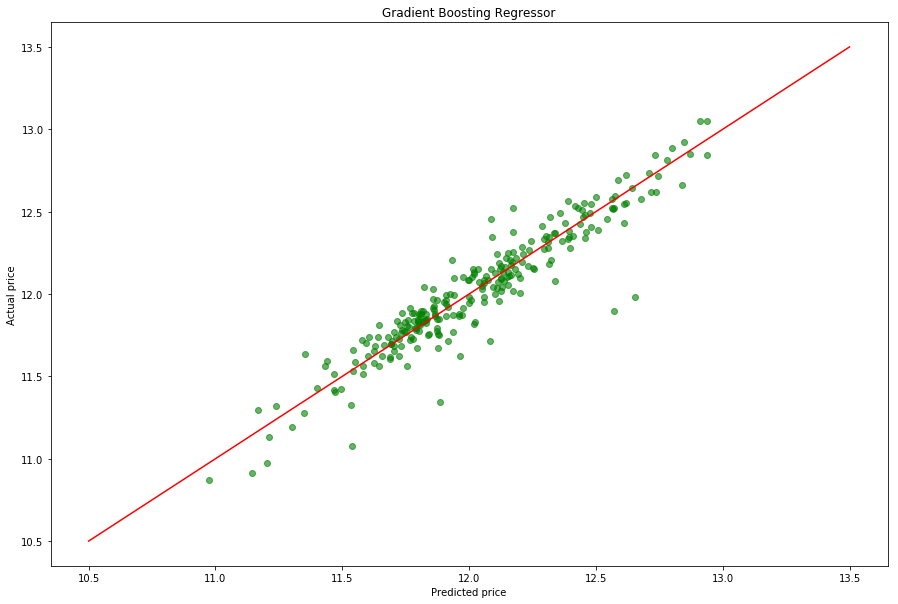

In [259]:
# Best model 
best_model = GradientBoostingRegressor()
best_model.fit(X_train,Y_train)

best_predictions = best_model.predict(X_real)
print("[INFO] RMSE : {}".format(round(np.sqrt(mean_squared_error(best_predictions, y_real)), 3)))

plt.figure(figsize=(15,10))
plt.scatter(best_predictions, y_real, alpha=0.6, c='g')
plt.plot([10.5,13.5],[10.5,13.5],"r")
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.title("Gradient Boosting Regressor")
plt.show()

[INFO] RMSE : 0.129


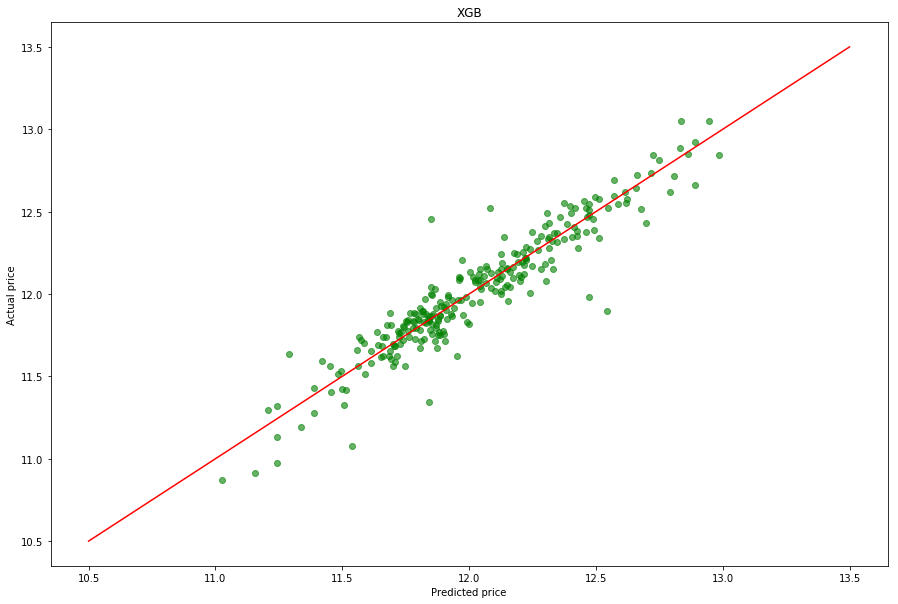

In [266]:
# Second best model 
best_xgbmodel = xgb.XGBRegressor()
best_xgbmodel.fit(X_train,Y_train)

best_xgbpredictions = best_xgbmodel.predict(X_real)
print("[INFO] RMSE : {}".format(round(np.sqrt(mean_squared_error(best_xgbpredictions, y_real)), 3)))

plt.figure(figsize=(15,10))
plt.scatter(best_xgbpredictions, y_real, alpha=0.6, c='g')
plt.plot([10.5,13.5],[10.5,13.5],"r")
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.title("XGB")
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

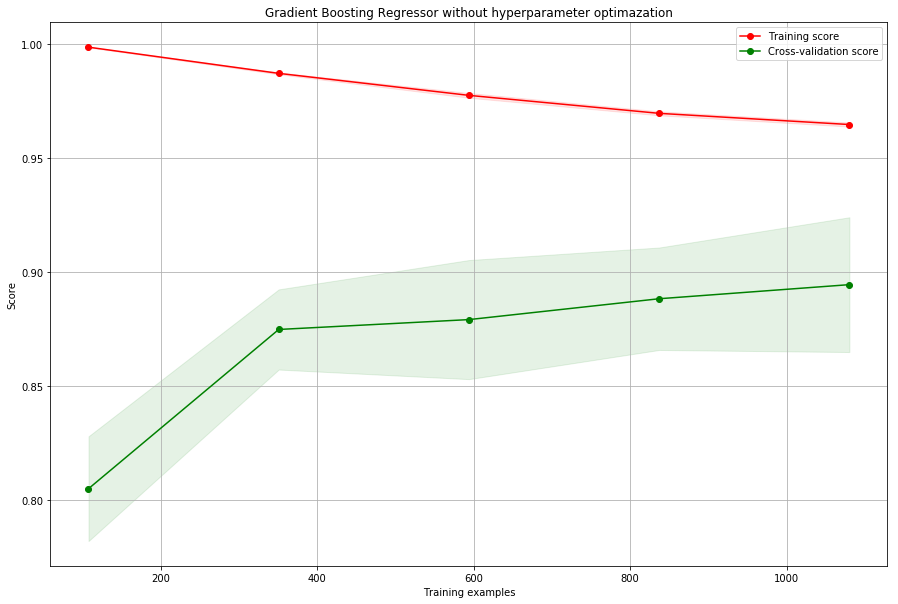

In [268]:
plot_learning_curve(best_model, "Gradient Boosting Regressor without hyperparameter optimazation", X, y, cv=10, n_jobs = 4)

In [21]:
#hyperparameter optimazation
from sklearn.grid_search import GridSearchCV

def hyperparameterOpt(estimator, params, cv, n_jobs=4):
    model_to_estimate = GridSearchCV(estimator = estimator, param_grid = params, cv = cv, n_jobs = n_jobs, verbose = 1)
    model_to_estimate.fit(X_train, Y_train)
    print("Best parameters from GridSearchCV: ", model_to_estimate.best_estimator_)
    return model_to_estimate.best_estimator_




In [31]:
param_gridGBR = {'n_estimators':[2000],
              'learning_rate': [0.01],
              'max_depth':[4],
              'min_samples_leaf':[5], 
              'max_features':[1.0,0.5,0.3,0.2,0.1,0.08,0.05]
             }

modelGBR = GradientBoostingRegressor()
best_parametersGBR = hyperparameterOpt(modelGBR, param_gridGBR, cv = 10)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   51.3s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:   59.9s finished


Best parameters from GridSearchCV:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=0.1,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=2000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [34]:
param_gridXGB = {'n_estimators':[2500],
              'learning_rate': [0.01],
              'max_depth':[4],
              'min_samples_leaf':[5], 
              'max_features':[1.0]
             }
modelXGB = xgb.XGBRegressor()
best_parametersXGB = hyperparameterOpt(modelXGB, param_gridXGB, cv = 10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  2.0min finished


Best parameters from GridSearchCV:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=4, max_features=1.0,
       min_child_weight=1, min_samples_leaf=5, missing=None,
       n_estimators=2500, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)


RMSE : 0.124


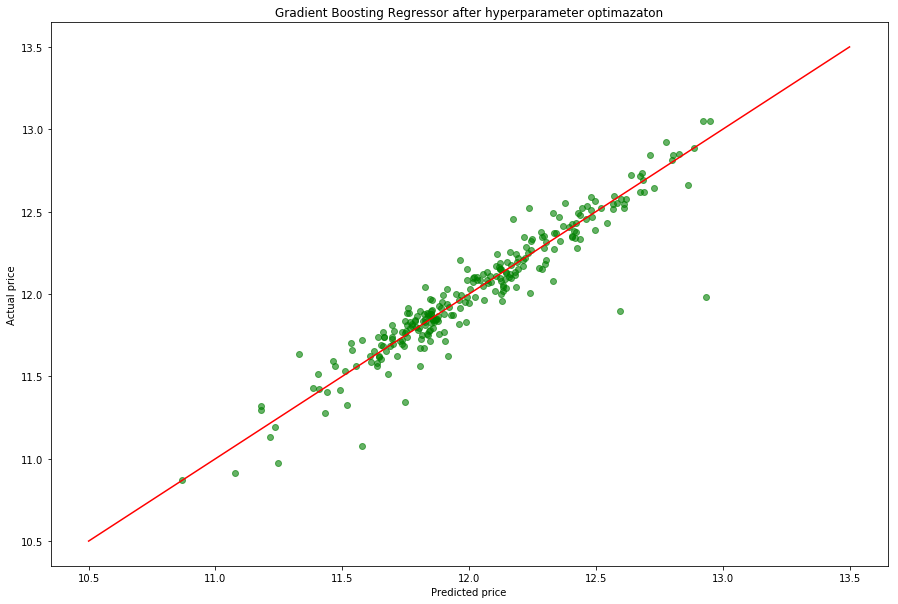

In [27]:
# Best models 
best_optimized_model = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.01, max_depth=4, min_samples_leaf=5, max_features=0.1)
best_optimized_model.fit(X_train,Y_train)

best_optimized_predictions = best_optimized_model.predict(X_real)
print("RMSE : {}".format(round(np.sqrt(mean_squared_error(best_optimized_predictions, y_real)), 3)))

plt.figure(figsize=(15,10))
plt.scatter(best_optimized_predictions, y_real, alpha=0.6, c='g')
plt.plot([10.5,13.5],[10.5,13.5],"r")
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.title("Gradient Boosting Regressor after hyperparameter optimazaton")
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

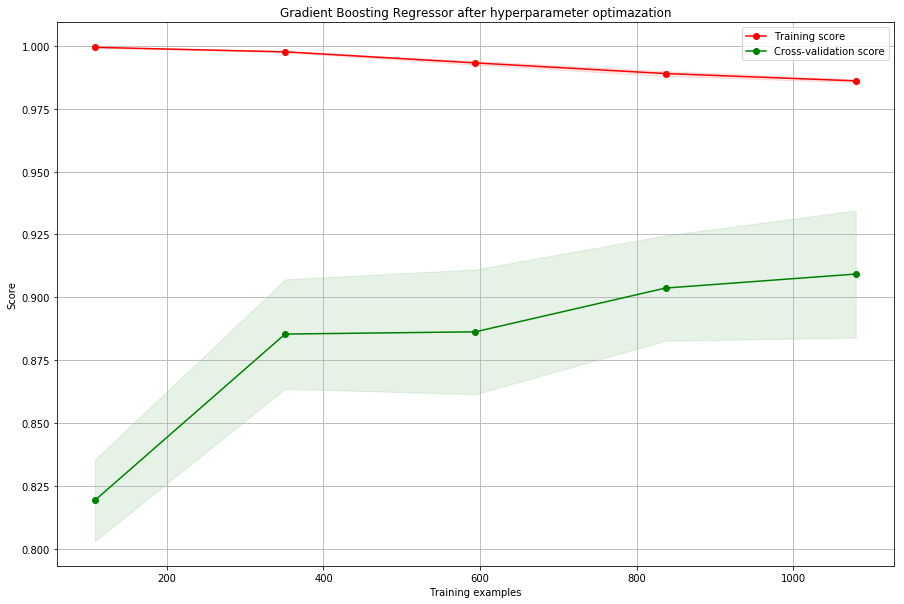

In [257]:
plot_learning_curve(best_optimized_model, "Gradient Boosting Regressor after hyperparameter optimazation", X, y, cv=10, n_jobs = 4)

RMSE : 0.123


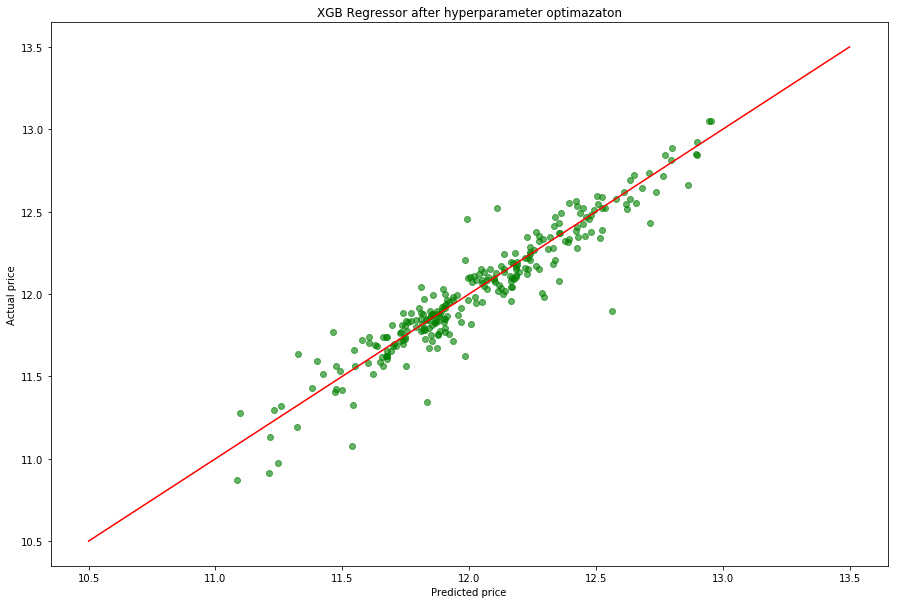

In [39]:
second_optimized_model = xgb.XGBRegressor(n_estimators=2500, learning_rate=0.01, max_depth=4, min_samples_leaf=5, max_features=1)
second_optimized_model.fit(X_train,Y_train)

second_optimized_predictions = second_optimized_model.predict(X_real)
print("RMSE : {}".format(round(np.sqrt(mean_squared_error(second_optimized_predictions, y_real)), 3)))

plt.figure(figsize=(15,10))
plt.scatter(second_optimized_predictions, y_real, alpha=0.6, c='g')
plt.plot([10.5,13.5],[10.5,13.5],"r")
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.title("XGB Regressor after hyperparameter optimazaton")
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

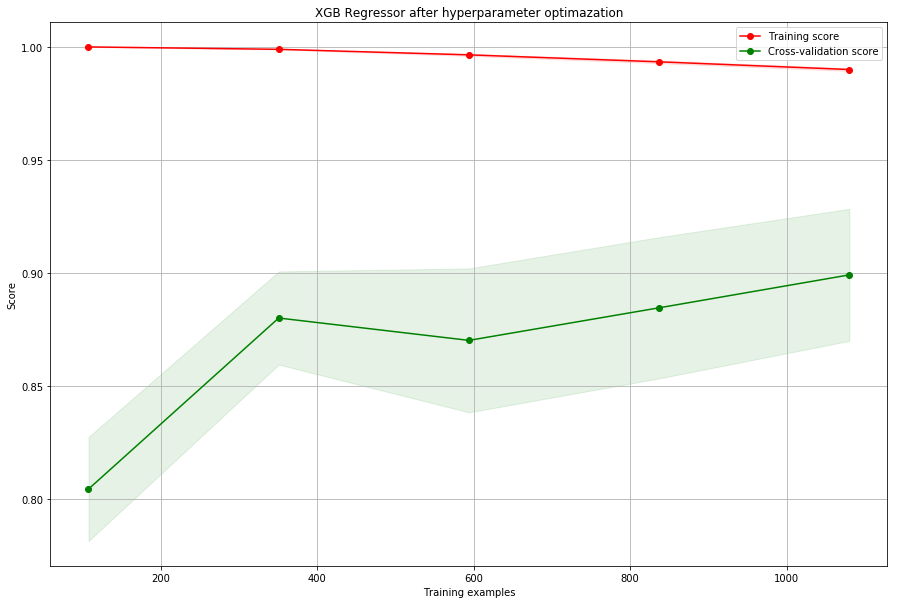

In [37]:
plot_learning_curve(second_optimized_model, "XGB Regressor after hyperparameter optimazation", X, y, cv=10, n_jobs = 4)